# Experiment on Different Time-series Similarity Measures 1

### Loading

In [105]:
# load image and libraries
%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from itertools import groupby
from scipy import signal
from sklearn import preprocessing
import pandas as pd

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 150 # 200 e.g. is really fine, but slower

root_path = './processed_datasets/'
datasets = ['has', 'sp', 'fp', 'rb', 'sd', 'sr', 'hasb', 'ihas']

# load ground truth
ori_data_X = []
ori_data_y = []
sketch_X = []
for dataset in datasets:
    file_name = root_path + 'original_' + dataset  
    ori_data_X.append(np.load(file_name + '_X' + '.npy'))
    ori_data_y.append(np.load(file_name + '_y' + '.npy'))
    file_name = root_path + 'sketch_' + dataset + '.npy'
    sketch_X.append(np.load(file_name, allow_pickle=True)[:100])
print(f"number of loaded samples per class: {[len(x) for x in sketch_X]}")
print(f"Original data: {len(ori_data_X)} datasets")
print(f"Sketch data: {len(sketch_X)} datasets")


number of loaded samples per class: [100, 100, 100, 100, 100, 100, 100, 100]
Original data: 8 datasets
Sketch data: 8 datasets


### Sliding Window

In [106]:
def sliding_window(ori_series, clip_series, measure):
    """
    Compute the similarities of the original and the clipped series using sliding window
    input: original time series, clipped series, similarity measure function
    output: similarity_distribution, matching result, i.e., starting and ending points
    """
    ori_len = ori_series.shape[0]
    clip_len = clip_series.shape[0]
    if ori_len < clip_len:
        return None

    # compute the similarity between the original and the clipped series
    dist = []
    # compute the similarity between the original and the clipped series using sliding window
    for i in range(ori_len - clip_len + 1):
        dist.append(measure(ori_series[i:i+clip_len], clip_series))
    # find the maximum similarity and the corresponding starting and ending points
    min_idx = np.argmin(dist)
    return dist, [min_idx, min_idx + clip_len - 1]


In [107]:
def pointwise_exp(ori_data_X, ori_data_y, sketch_X, measure):
    results = []
    for i, dataset in enumerate(datasets):
        original = ori_data_X[i]
        label = ori_data_y[i]
        dummy_record = []
        for sample in sketch_X[i]:
            clip =  signal.resample(sample, label[1]-label[0]+1)
            sim_dist, pred_loc = sliding_window(original, clip, measure)
            dummy_record.append([sim_dist, pred_loc])
        results.append(dummy_record)
    return results

### Define Metrics

#### Euclidean Distance

In [108]:
def euclidean_distance(x,y):
    t = preprocessing.Normalizer()
    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)
    return np.linalg.norm(t.transform(x) - t.transform(y))

#### DTW

### Qetch Algorithm

In [109]:
#Qetch Algorithm -- inclomplete --

def width(series):
    # Should return width of series


    return 
    
def height(series):
    # Should return width of series

    return 

def get_LDE(sketch_split,Candidate_split,Gx,Gy):
    Rx = width(Candidate_split)/(Gx * width(sketch_split))    
    Ry = height(Candidate_split)/(Gy * height(sketch_split))  
    return (np.log(Rx)**2)+(np.log(Ry)**2)

def get_ShapeError(Sketch,Candidate,Gx,Gy,k):


    return 
def calculatDistance(Sketch, Candidate,k):
    # Calculating Global non uniform Scaling facctors
    Gx = width(Candidate)/width(Sketch)
    Gy = height(Candidate)/height(Sketch)
    # Calculating Shape error
    SE = get_ShapeError(Sketch,Candidate,Gx,Gy)
    sketch_split = np.split(Sketch,k)
    Candidate_split = np.split(Candidate,k)
    # Calculating Local distortion errors
    LDE = 0
    for i in range(k):
        LDE += get_LDE(Sketch[i],Candidate[i],Gx,Gy,k)

    # Calculating total error
    Dist = LDE + SE
    return Dist


### Experiment 1: Matching Performance

#### Analysis

In [110]:
def analyze_results(results, ori_data_X=ori_data_X, ori_data_Y=ori_data_y, datasets=datasets):
    d = {'Dataset':[], 'Number of samples':[], 'Average distance':[], 'Average location error (%)':[]}
    
    for i in range(len(results)):
        d['Dataset'].append(datasets[i])
        d['Number of samples'].append(len(results[i]))
        d['Average distance'].append(np.mean([np.max(x[0]) for x in results[i]]))
        d['Average location error (%)'].append(np.mean([np.abs(x[1][0] - ori_data_y[i][0])/ ori_data_X[i].shape[0]*100 for x in results[i]]))
        dummy = {"Dataset": datasets[i], "Number of samples": len(results[i]), "Average distance": np.mean([np.max(x[0]) for x in results[i]]),
                 "Average location error (%)": np.mean([np.abs(x[1][0] - ori_data_y[i][0])/ ori_data_X[i].shape[0]*100 for x in results[i]])}
    df = pd.DataFrame(d)
    display(df)
    display(df.iloc[:,[2,3]].describe())
    print('--------------------Overall:------------------------------------')
    print(f'Average location error w.r.t. total length: {np.mean([np.mean([np.abs(x[1][0] - ori_data_y[i][0])/ ori_data_X[i].shape[0]*100 for x in results[i]]) for i in range(len(results))])}%')
    plt.figure()
    for i in range(len(results)):
        ax = plt.subplot(3,3,i+1)
        plt.tight_layout()
        plt.title(f"Dataset: {datasets[i]}")
        plt.xlabel("Time")
        plt.ylabel("Distance")
        plt.plot(results[i][0][0])
        plt.plot(results[i][0][1], [0.5, 0.5], marker='*', ls='none')
        plt.plot(ori_data_y[i], [0.5, 0.5], marker='o', color='r', ls='none')
    plt.legend(['Distance', 'Predicted', 'Ground Truth'])
    plt.show()
    return df

#### Get results

,Dataset,Number of samples,Average distance,Average location error (%)
0,has,100,0.868820,7.251208
1,sp,100,0.894325,17.347826
2,fp,100,1.026507,12.874396
3,rb,100,1.139434,1.932367
4,sd,100,0.586013,3.045894
5,sr,100,1.239033,23.241546
6,hasb,100,0.669684,8.983092
7,ihas,100,0.752768,10.975904


,Average distance,Average location error (%)
count,8.000000,8.000000
mean,0.897073,10.706529
std,0.227572,7.137291
min,0.586013,1.932367
25%,0.731997,6.199879
50%,0.881572,9.979498
75%,1.054739,13.992754
max,1.239033,23.241546


--------------------Overall:------------------------------------
Average location error w.r.t. total length: 10.706529014609162%


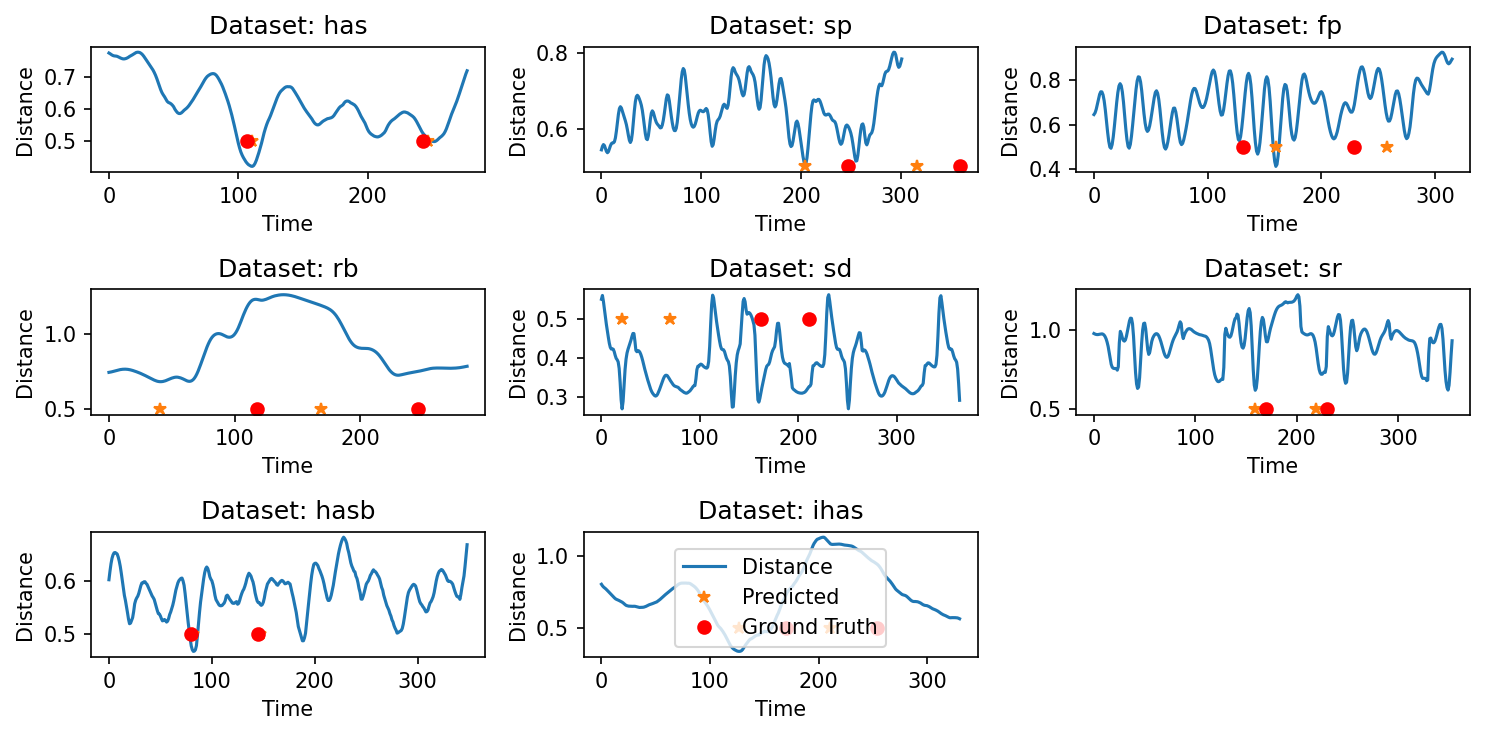

In [111]:
results_eu = pointwise_exp(ori_data_X, ori_data_y, sketch_X, euclidean_distance)
analytics_eu = analyze_results(results_eu)